# Behavioural Cloning Project

## 1. Import Data from Folders

In [7]:
import csv
import os
from sklearn.model_selection import train_test_split

# Load data from file.
filename = 'data_new'
samples = os.listdir(filename)
lines = []
zeros = 0

# Loop through all directories.
for sample in samples:
    current_dir = './' + filename + '/' + sample
    with open(current_dir + '/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            
            # Filter sections of zero steering.
            if float(line[3]) != 0.0:
                zeros = 0
            else:
                zeros += 1
            
            # Append images.
            if zeros < 5:
                line[0] = current_dir + '/IMG/' + line[0].split('/')[-1]
                line[1] = current_dir + '/IMG/' + line[1].split('/')[-1]
                line[2] = current_dir + '/IMG/' + line[2].split('/')[-1]
                lines.append(line)

# Split data into training and validation set.
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

## 2. Image Augmentation Function

In [8]:
from random import randint as rand

def augment(image):
    """Image Augmentation Function
    
    Applies a random rotation, translation, and brightness
    effect to the input image.
    
    Returns:
      Image, RGB image.
    """
    # Image Parameters.
    rows,cols,depth = image.shape

    # Apply Random Translation.
    x_shift, y_shift = rand(0,8)/100, rand(0,5)/100
    M = np.float32([[1,0,cols*x_shift],[0,1,rows*y_shift]])
    image = cv2.warpAffine(image,M,(cols,rows))

    # Apply Random Rotation.
    rotate = rand(-10,10)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),rotate,1)
    image = cv2.warpAffine(image,M,(cols,rows))

    # Apply Random Brightness.
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image[:,:,2] = image[:,:,2]*random_bright
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    
    return image

## 3. Populate Images and Measurements

In [9]:
import cv2
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

%matplotlib inline

def generator(samples, batch_size=32):
    """Data Generator to Prevent Overflow
    
    Returns:
      List, images of left/right/center camera.
      List, steering angles.
    """
    steering_bias_left = 0.25
    steering_bias_right = -0.25
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for batch_sample in batch_samples:
                # Collect Images & Measurements.
                image_c = cv2.imread(batch_sample[0])
                image_l = cv2.imread(batch_sample[1])
                image_r = cv2.imread(batch_sample[2])
                measurement_c = float(batch_sample[3])
                measurement_l = float(measurement_c) + steering_bias_left
                measurement_r = float(measurement_c) + steering_bias_right
                
                # Add Normal & Mirrored Images.
                images.append(augment(image_c))
                images.append(augment(np.fliplr(image_c)))
                images.append(augment(image_l))
                images.append(augment(np.fliplr(image_l)))
                images.append(augment(image_r))
                images.append(augment(np.fliplr(image_r)))

                # Add Normal & Mirrored Steering.
                measurements.append(measurement_c)
                measurements.append(-measurement_c)
                measurements.append(measurement_l)
                measurements.append(-measurement_l)
                measurements.append(measurement_r)
                measurements.append(-measurement_r)

            # Set data into array.
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

# Compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

## 4. Model Architecture.

In [10]:
from keras.models import Sequential
from keras.layers import Activation, Cropping2D, Dense
from keras.layers import Dropout, Flatten, Lambda
from keras.layers import Convolution2D

# NVIDIA Architecture.
model = Sequential()

# Pre-Process Data.
model.add(Lambda(lambda x: x / 127.5 -1, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((50,20),(0,0))))

# Add Three 5x5 Convolution Layers.
model.add(Convolution2D(24, 5, 5, subsample=(2,2), border_mode='same', activation='relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), border_mode='same', activation='relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), border_mode='same', activation='relu'))
model.add(Dropout(0.25))

# Add Two 3x3 Convolution Layers.
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Dropout(0.25))

# Flatten Layers.
model.add(Flatten())

# Connect the layers.
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.40))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.40))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.40))
model.add(Dense(1))

# Compile the Model.
model.compile(loss='mse', optimizer='adam')

#https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/

## 5. Train the Model.

Epoch 1/8
13392/13392 [==============================] - 52s - loss: 0.0358 - val_loss: 0.0292
Epoch 2/8
13392/13392 [==============================] - 50s - loss: 0.0318 - val_loss: 0.0248
Epoch 3/8
13392/13392 [==============================] - 50s - loss: 0.0295 - val_loss: 0.0222
Epoch 4/8
13392/13392 [==============================] - 50s - loss: 0.0274 - val_loss: 0.0229
Epoch 5/8
13392/13392 [==============================] - 50s - loss: 0.0268 - val_loss: 0.0210
Epoch 6/8
13392/13392 [==============================] - 50s - loss: 0.0242 - val_loss: 0.0169
Epoch 7/8
13392/13392 [==============================] - 50s - loss: 0.0228 - val_loss: 0.0156
Epoch 8/8
13392/13392 [==============================] - 50s - loss: 0.0236 - val_loss: 0.0155


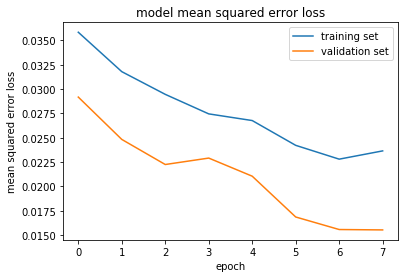

In [12]:
history_object = model.fit_generator(
    train_generator, 
    samples_per_epoch=len(train_samples)*6, 
    validation_data=validation_generator, 
    nb_val_samples=len(validation_samples)*6,
    nb_epoch=3) # was 3

## model_new12.h5 (5 epochs)
## - makes bridge
## - makes dirt corner
## - makes second corner
## - PASS

# Save Training Model.
model.save('model_new16.h5')

# Visualize the Loss.
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()